###  Neural Networks for Handwritten Digit Recognition, Binary

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from autils import *
%matplotlib inline 
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

<a name="2"></a>
## 2 - Neural Networks

In Course 1, you implemented logistic regression. This was extended to handle non-linear boundaries using polynomial regression. For even more complex scenarios such as image recognition, neural networks are preferred.

<a name="2.1"></a>
### 2.1 Problem Statement

In this exercise, you will use a neural network to recognize two handwritten digits, zero and one. This is a binary classification task. Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. You will extend this network to recognize all 10 digits (0-9) in a future assignment. 

This exercise will show you how the methods you have learned can be used for this classification task.

<a name="2.2"></a>
### 2.2 Dataset

You will start by loading the dataset for this task. 
- The `load_data()` function shown below loads the data into variables `X` and `y`


- The data set contains 1000 training examples of handwritten digits $^1$, here limited to zero and one.  

    - Each training example is a 20-pixel x 20-pixel grayscale image of the digit. 
        - Each pixel is represented by a floating-point number indicating the grayscale intensity at that location. 
        - The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. 
        - Each training example becomes a single row in our data matrix `X`. 
        - This gives us a 1000 x 400 matrix `X` where every row is a training example of a handwritten digit image.

$$X = 
\left(\begin{array}{cc} 
--- (x^{(1)}) --- \\
--- (x^{(2)}) --- \\
\vdots \\ 
--- (x^{(m)}) --- 
\end{array}\right)$$ 

- The second part of the training set is a 1000 x 1 dimensional vector `y` that contains labels for the training set
    - `y = 0` if the image is of the digit `0`, `y = 1` if the image is of the digit `1`.

$^1$<sub> This is a subset of the MNIST handwritten digit dataset (http://yann.lecun.com/exdb/mnist/)</sub>

In [20]:
X,y=load_data()
X.shape


(1000, 400)

In [21]:
print(f" the first element of x is :   {X[0]}")
print ('The first element of y is: ', y[0,0])
print ('The last element of y is: ', y[-1,0])

 the first element of x is :   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0000000

In [40]:
print ('The shape of X is: ' + str(X.shape))
print ('The shape of y is: ' + str(y.shape))

The shape of X is: (1000, 400)
The shape of y is: (1000, 1)


In [23]:
# to ignore FutureWarning messages when they occur.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

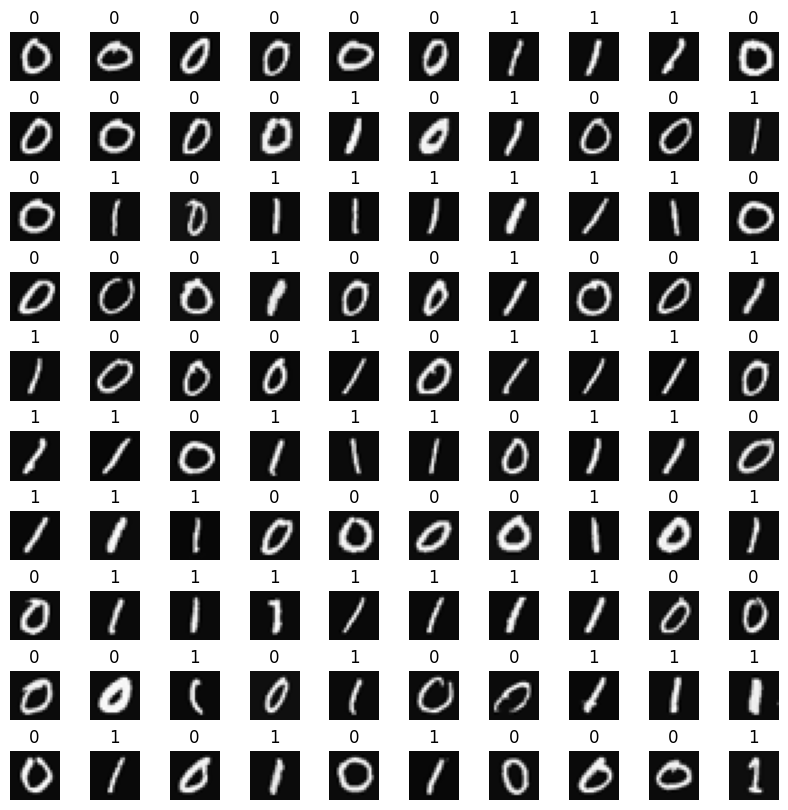

In [24]:
# visualize

m, n = X.shape #m=1000 n=400

fig, axes = plt.subplots(10,10, figsize=(8,8))
fig.tight_layout(pad=0.1)

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='grey')
    
    # Display the label above the image
    ax.set_title(y[random_index,0])
    ax.set_axis_off()

<a name="2.4"></a>
### 2.4 Tensorflow Model Implementation

Tensorflow models are built layer by layer. A layer's input dimensions ($s_{in}$ above) are calculated for you. You specify a layer's *output dimensions* and this determines the next layer's input dimension. The input dimension of the first layer is derived from the size of the input data specified in the `model.fit` statment below. 
>**Note:** It is also possible to add an input layer that specifies the input dimension of the first layer. For example:  
`tf.keras.Input(shape=(400,)),    #specify input shape`  
We will include that here to illuminate some model sizing.

<a name="2.3"></a>
### 2.3 Model representation

The neural network you will use in this assignment is shown in the figure below. 
- This has three dense layers with sigmoid activations.
    - Recall that our inputs are pixel values of digit images.
    - Since the images are of size $20\times20$, this gives us $400$ inputs  
    
<img src="C2_W1_Assign1.PNG" width="500" height="400">

- The parameters have dimensions that are sized for a neural network with $25$ units in layer 1, $15$ units in layer 2 and $1$ output unit in layer 3. 

    - Recall that the dimensions of these parameters are determined as follows:
        - If network has $s_{in}$ units in a layer and $s_{out}$ units in the next layer, then 
            - $W$ will be of dimension $s_{in} \times s_{out}$.
            - $b$ will a vector with $s_{out}$ elements
  
    - Therefore, the shapes of `W`, and `b`,  are 
        - layer1: The shape of `W1` is (400, 25) and the shape of `b1` is (25,)
        - layer2: The shape of `W2` is (25, 15) and the shape of `b2` is: (15,)
        - layer3: The shape of `W3` is (15, 1) and the shape of `b3` is: (1,)
>**Note:** The bias vector `b` could be represented as a 1-D (n,) or 2-D (n,1) array. Tensorflow utilizes a 1-D representation and this lab will maintain that convention. 
               

In [25]:
# model 
model=Sequential(
    [
        tf.keras.Input(shape=(400,)),
        tf.keras.layers.Dense(units=25,activation='sigmoid'),
        tf.keras.layers.Dense(units=15,activation='sigmoid'),
        tf.keras.layers.Dense(units=1, activation='sigmoid')
    ], name="new_model"
    
    )

In [26]:
model.summary()

Model: "new_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 25)             │        10,025 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 15)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,431 (40.75 KB)

 Trainable params: 10,431 (40.75 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
L1_num_params = 400 * 25 + 25  # W1 parameters  + b1 parameters
L2_num_params = 25 * 15 + 15   # W2 parameters  + b2 parameters
L3_num_params = 15 * 1 + 1     # W3 parameters  + b3 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params, ",  L3 params = ", L3_num_params )

L1 params =  10025 , L2 params =  390 ,  L3 params =  16


In [28]:
[layer1,layer2,layer3]=model.layers

In [29]:
# examine the weights

W1,b1=layer1.get_weights()
W2,b2=layer2.get_weights()
W3,b3=layer3.get_weights()

print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 1), b3 shape = (1,)


In [30]:
print(model.layers[2].weights)

[<KerasVariable shape=(15, 1), dtype=float32, path=new_model/dense_5/kernel>, <KerasVariable shape=(1,), dtype=float32, path=new_model/dense_5/bias>]


The following code will define a loss function and run gradient descent to fit the weights of the model to the training data. 

In [31]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001)
)
model.fit(
    X,y,
    epochs=20
)

Epoch 1/20


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step - loss: 0.7774 
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.6079
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.4763
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 0.3704
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 0.2871
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - loss: 0.2222
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 0.1706
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.1381
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 0.1109
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 0.0940
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - loss: 0.0765
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 0.0726
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 0.0568
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 0.0492
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 0.0437

In [32]:
# prediction 


prediction = model.predict(X[0].reshape(1,400))  # a zero
print(f" predicting a zero: {prediction}")
prediction = model.predict(X[500].reshape(1,400))  # a one
print(f" predicting a one:  {prediction}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
 predicting a zero: [[0.02076836]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
 predicting a one:  [[0.97310734]]


Let's compare the predictions vs the labels for a random sample of 64 digits. This takes a moment to run.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

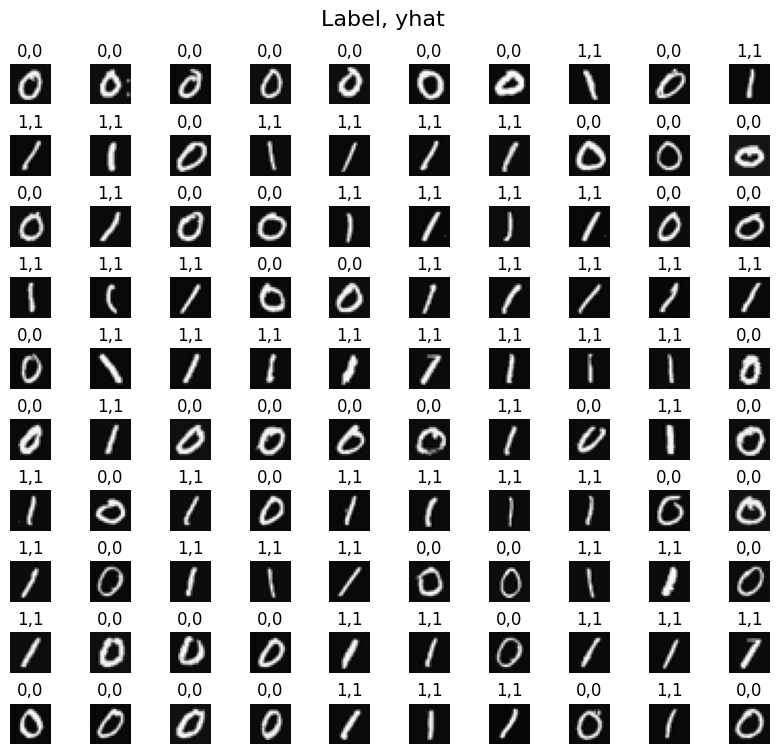

In [33]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(10,10, figsize=(8,8))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Predict using the Neural Network
    prediction = model.predict(X[random_index].reshape(1,400))
    if prediction >= 0.5:
        yhat = 1
    else:
        yhat = 0
    
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]},{yhat}")
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=16)
plt.show()

### using numpy model  

In [34]:
def Dense(a_in,W,b,g):
    units = W.shape[1]
    a_out = np.zeros(units)
    for j in range(units):
        w=W[:,j]
        z = np.dot(w, a_in) + b[j]
        a_out[j] = g(z)
    return(a_out)


In [36]:
test_c2(Dense)

In [37]:
# neural network

def my_sequential(x, W1, b1, W2, b2, W3, b3):
    a1 = Dense(x,  W1, b1, sigmoid)
    a2 = Dense(a1, W2, b2, sigmoid)
    a3 = Dense(a2, W3, b3, sigmoid)
    return(a3)   

In [ ]:
# copy the weight from tensorflow

W1_tmp,b1_tmp = layer1.get_weights()
W2_tmp,b2_tmp = layer2.get_weights()
W3_tmp,b3_tmp = layer3.get_weights()

In [ ]:
# make predictions
prediction = my_sequential(X[0], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print( "yhat = ", yhat, " label= ", y[0,0])
prediction = my_sequential(X[500], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print( "yhat = ", yhat, " label= ", y[500,0])

yhat =  0  label=  0
yhat =  1  label=  1


### visualize it with the tf prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/tmp/ipykernel_23976/1208669724.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  my_yhat = int(my_prediction >= 0.5)
/tmp/ipykernel_23976/1208669724.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tf_yhat = int(tf_prediction >= 0.5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

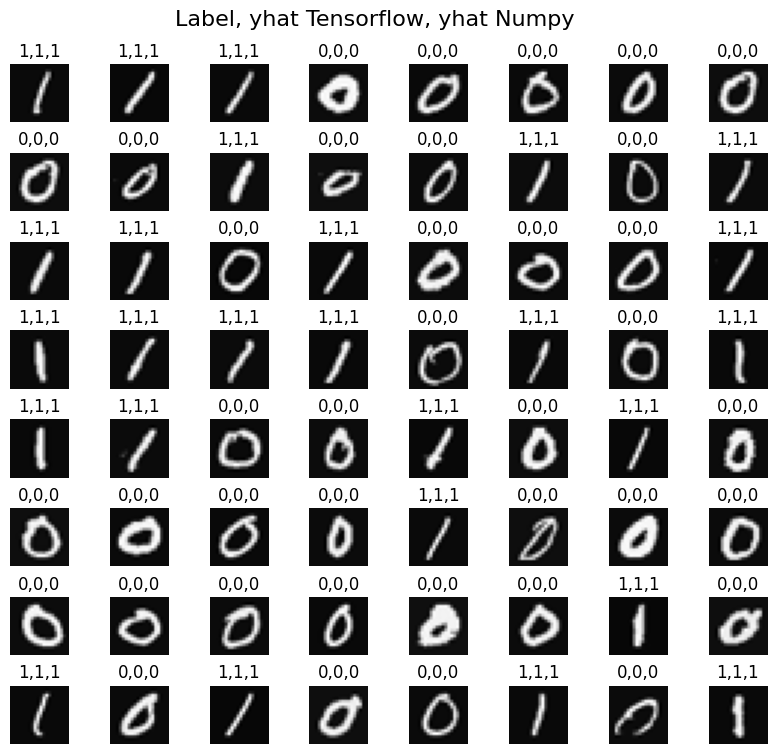

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')

    # Predict using the Neural Network implemented in Numpy
    my_prediction = my_sequential(X[random_index], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
    my_yhat = int(my_prediction >= 0.5)

    # Predict using the Neural Network implemented in Tensorflow
    tf_prediction = model.predict(X[random_index].reshape(1,400))
    tf_yhat = int(tf_prediction >= 0.5)
    
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]},{tf_yhat},{my_yhat}")
    ax.set_axis_off() 
fig.suptitle("Label, yhat Tensorflow, yhat Numpy", fontsize=16)
plt.show()

### vectorized numpy model prediction

In [ ]:
def my_dense_v(A_in, W, b, g):
    Z = np.matmul(A_in, W) +b
    A_out = g(Z)
    return(A_out)

In [ ]:
test_c3(my_dense_v)

All tests passed!


In [ ]:
# neural layers

def my_sequential_v(X, W1, b1, W2, b2, W3, b3):
    A1 = my_dense_v(X,  W1, b1, sigmoid)
    A2 = my_dense_v(A1, W2, b2, sigmoid)
    A3 = my_dense_v(A2, W3, b3, sigmoid)
    return(A3)

In [ ]:
# copy the wegihts

W1_tmp,b1_tmp = layer1.get_weights()
W2_tmp,b2_tmp = layer2.get_weights()
W3_tmp,b3_tmp = layer3.get_weights()

In [ ]:
#prediction
Prediction = my_sequential_v(X, W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
Prediction.shape

TensorShape([1000, 1])

We'll apply a threshold of 0.5 as before, but to all predictions at once.

In [ ]:
Yhat = (Prediction >= 0.5).numpy().astype(int)
print("predict a zero: ",Yhat[0], "predict a one: ", Yhat[500])

predict a zero:  [0] predict a one:  [1]


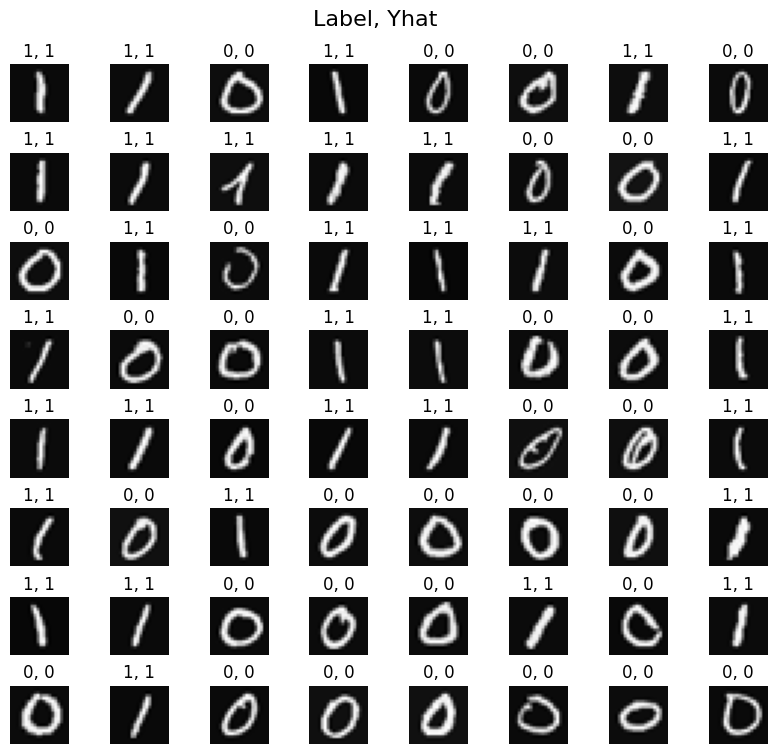

In [ ]:
# visualize
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# You do not need to modify anything in this cell

m, n = X.shape

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.tight_layout(pad=0.1, rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i, ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20, 20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
   
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]}, {Yhat[random_index, 0]}")
    ax.set_axis_off() 
fig.suptitle("Label, Yhat", fontsize=16)
plt.show()

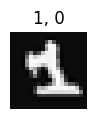

In [ ]:
fig = plt.figure(figsize=(1, 1))
errors = np.where(y != Yhat)
random_index = errors[0][0]
X_random_reshaped = X[random_index].reshape((20, 20)).T
plt.imshow(X_random_reshaped, cmap='gray')
plt.title(f"{y[random_index,0]}, {Yhat[random_index, 0]}")
plt.axis('off')
plt.show()